In [1]:
from hmmlearn import hmm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
#设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
#设置正常显示字符
plt.rcParams['axes.unicode_minus'] = False


## 读取文件

In [2]:

def read_file(file):
    data_raw = pd.read_excel(file,index_col=0)
    ## 对于导出数据
    if len(data_raw.columns)>6:
        data_raw.set_index('日期',inplace=True)    
        data_raw=data_raw.iloc[:-2,1:-1]
        data_raw.columns='open high close low volume'.split(' ')

    ## 对于windpy 导出数据
    else:
        pass
    return data_raw

file='./T_30min.xlsx'
data_raw=read_file(file)
data_raw

,open,high,low,close,volume
2017-12-18 09:45:00,92.985,93.120,92.970,93.070,6729
2017-12-18 10:15:00,93.075,93.080,93.010,93.030,3445
2017-12-18 10:45:00,93.030,93.045,92.945,92.955,2849
2017-12-18 11:15:00,92.960,93.010,92.950,92.995,1295
2017-12-18 13:15:00,92.990,93.000,92.965,92.990,1269
...,...,...,...,...,...
2020-12-17 13:30:00,97.245,97.280,97.220,97.265,4083
2020-12-17 14:00:00,97.260,97.290,97.255,97.260,3955
2020-12-17 14:30:00,97.260,97.280,97.215,97.225,4976
2020-12-17 15:00:00,97.225,97.250,97.210,97.210,3783


## 划分训练集测试集


In [3]:
train=data_raw.iloc[:-int(len(data_raw)/3)]

test=data_raw.iloc[-int(len(data_raw)/3):]
print(len(train),len(test))

4380 2189


# 切换合约日期（用于考虑主力合约切换）


In [4]:
# df_chg=pd.read_excel('主力切换.xlsx',sheet_name='Sheet2',index_col=0)
# df_chg['change']=(df_chg!=df_chg.shift(1))
# change_day=df_chg[df_chg['change']==True] # 前面的数据用不到
# # 此处显示的日期为新券的第一天
# change_day.tail()

In [5]:
# 这句是为了剔除九点之前的，暂不用
# ((pd.Series(list(map(lambda x:str(x)[-8:] ,data_raw.index)),index=data_raw.index)>'09:31:00'))

4380 2189


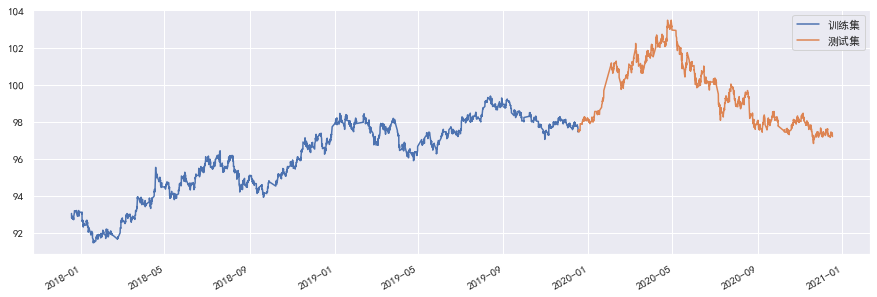

In [6]:
# 15:10表示15:05-15:10


data_raw=data_raw[((pd.Series(list(map(lambda x:str(x)[-8:] ,data_raw.index)),index=data_raw.index)>'09:31:00'))] # 去掉盘前交易
train=data_raw.iloc[:-int(len(data_raw)/3)]

test=data_raw.iloc[-int(len(data_raw)/3):]
print(len(train),len(test))


plt.figure(figsize=(15,5))
# plt.subplot(121)
train.close.plot()

test.close.plot()
plt.legend(['训练集','测试集'])
plt.show()

In [7]:
n = 2 # 隐藏状态个数

In [8]:
def pre_process(data):
    """
    这个函数进行数据预处理，返回训练所需数据
    """
    volume = data['volume']
    close = data['close']
    
    bday=6 # 所需获取的提前的数据天数
    
    logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low'])) #时段内振幅收益
    logRet_1 = np.array(np.diff(np.log(close))) #  log(Pt/Pt-1)
    logRet_5 = np.log(np.array(close[bday:])) - np.log(np.array(close[:-bday])) # 五日（时期）收益率
    logVol_5 = np.log(np.array(volume[bday:])) - np.log(np.array(volume[:-bday])) #五日（时期）交易量变化
    Date = pd.to_datetime(data.index[bday:])
    
    # 保持所有的数据长度相同
    logDel = logDel[bday:]
    logRet_1 = logRet_1[bday-1:]
    close = close[bday:]
    
    info_df=pd.DataFrame({'Date': Date, 'close':close,'logReg_1': logRet_1}).set_index('Date') # 数据的基础信息
    A = np.column_stack([logDel, logRet_5])#,logVol_5,logRet_1])# 训练所用指标

    return info_df,A


In [9]:
def result_plot(result_df,only=False):
    """
    画图
    """
    
    hidden_states=result_df.states
    long = result_df.long  # 多头（买入）
    short = result_df.short  # 空头（卖出）
    
    if only !=True:
        plt.figure(figsize=(10, 10))

        """
        各时段所对应隐含状态
        """
        plt.subplot(221)
        for i in range(n):
            pos = (hidden_states == i)
            plt.plot(result_df.close[pos], 'o', label='hidden state %d' % i, lw=2)
            plt.legend()
        plt.title('各时段隐含状态')
        #     plt.show()

        """
        各隐含状态对应收益率图形
        """
        plt.subplot(222)
        for i in range(n):
            pos = (hidden_states == i)
            pos = np.append(1, pos[:-1]) # 后移一个时期
            result_df['state_ret%d' % i] = result_df.logReg_1.multiply(pos)
            data_i = np.exp(result_df['state_ret%d' % i].cumsum())
            plt.plot_date(result_df.index, data_i, '-', label='hidden state %d' % i)
            plt.legend()
        plt.title('各隐含状态对应收益率')
        #     plt.show()

        """
        各隐含状态占比图形
        """
        plt.subplot(223)
        countDict = dict()
        proportitionDict = dict()
        for i in range(n):
            countDict[i] = list(hidden_states).count(i) # 各个状态的数量
            proportitionDict[i] =list(hidden_states).count(i)/len(hidden_states)# 各个状态占比

        plt.pie(list(proportitionDict.values()),labels=list(proportitionDict))
        plt.legend()
        plt.title('各个隐含状态占比')
        #     plt.show()
    
        """
        策略收益率
        """
        plt.subplot(224)
    
    else:
        plt.figure(figsize=(10,6))

    # plt.figure(figsize=(10, 7))
#     plt.plot(result_df['stg_r'], 'r-',label='策略收益率') # 策略收益函数
    plt.plot(result_df['index_r'],'y',label='指数做多',linewidth=0.5) # 原收益函数
    plt.plot(result_df['adj_r'],'r',label='策略收益率') # 原收益函数
    
    plt.plot(result_df['index_r_short'],'g',label='指数做空',linewidth=0.5) # 原收益函数


    plt.title('策略收益率与指数收益率')
    plt.legend()
    plt.show()
    
    # return operate_df,long,short

In [10]:
def train_model(data):
    """
    传入DataFrame，用来训练模型
    """
    info_df,A=pre_process(data)
    model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=200000).fit(A) #拟合GaussianHMM
    return model


In [11]:

def model_order(model,data):
    """
    传入模型和DataFrame，
    获得各个隐含状态的收益率排名
    """
    info_df,A=pre_process(data)
    hidden_states = model.predict(A)  # 模型的预测
    info_df.insert(2, 'state',hidden_states)
    series = info_df.logReg_1
    templist = [] # 各个策略的最终收益率

    for i in range(n):
        pos = (hidden_states == i)
        pos = np.append(1, pos[:-1]) # 后移一个时期
        info_df['state_ret%d' % i] = series.multiply(pos)
        data_i = np.exp(info_df['state_ret%d' % i].cumsum())
        templist.append(data_i[-1])# 得到期末的某一种隐含状态对应的收益率
    templist = np.array(templist).argsort()
    return templist


def get_result(model,templist,data):    
    global fee,margin

    """
    传入模型和DataFrame，用模型预测隐含状态，并输出回测结果
    """
    info_df,A=pre_process(data)
    hidden_states = model.predict(A)  # 模型的预测
    """
    计算各项数据，并到df中
    """
    df=info_df
    
    if margin !=1:
        df['logReg_1']/=margin
    
    df['states']=hidden_states
    long = (hidden_states == templist[-1]) # 收益好的隐含状态对应买入
    short = (hidden_states == templist[0])  # 空头（卖出）
    long = np.append(0, long[:-1])
    short = np.append(0, short[:-1])
    df['long']=long
    df['short']=short
    df['stg_r_1']= info_df.logReg_1.multiply(long) - info_df.logReg_1.multiply(short) # 做多做空
    df['stg_r']=np.exp((df['stg_r_1']*1).cumsum())    
    df['index_r']=np.exp(df['logReg_1'].cumsum())
    
    df['index_r_short']=np.exp(-df['logReg_1'].cumsum())

    df['trade']=(df['long']!=df['long'].shift(1)) | (df['short']!=df['short'].shift(1))
    
    df['adj_r']=np.exp((df['stg_r_1']-(df['trade']+0)*fee).cumsum())

    
    print('策略收益率:{:.2f}%,基准收益率：{:.2f}%，超额收益率：{:.2f}%'.format((df['stg_r'][-1]-1)*100,(df['index_r'][-1]-1)*100,(df['stg_r'][-1]-df['index_r'][-1])*100))
    trade_num=(df['trade']+0).sum()
    print('调仓次数：{}，预估交易手续费：{:.2f}%'.format(trade_num,trade_num*fee))
    print('总时段数：{}，做空时段：{}'.format(len(df),df.short.sum()))

    return df

## 合约保证金2%，交易手续费3元一手，平今仓0%

In [12]:
# margin=0.02 # 保证金比率，如果考虑杠杆，则使用此
# fee=0.00015 # (2万元-->100万合约-->3元) # 但我们没有使用杠杆收益率

margin=1 # 保证金比率，不考虑杠杆，则使用此
fee=3/1000000 # (100万合约-->3元)

## 训练集训练

[[0.79960179 0.20039821]
 [0.00148463 0.99851537]]
策略收益率:5.15%,基准收益率：4.95%，超额收益率：0.20%
调仓次数：14，预估交易手续费：0.00%
总时段数：4374，做空时段：28


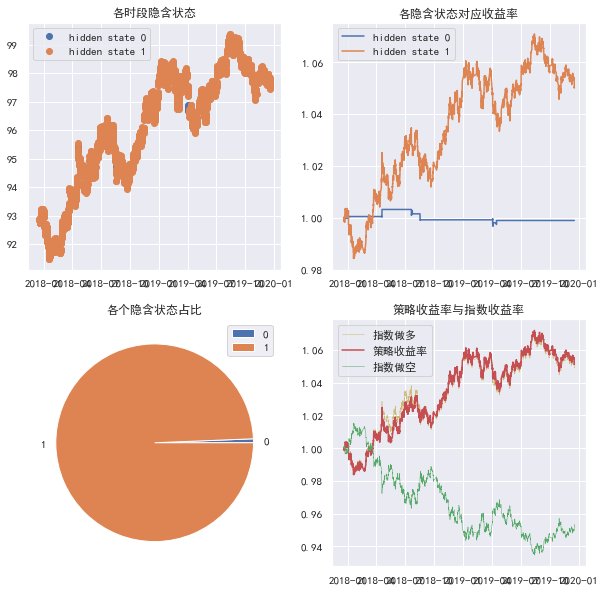

In [13]:
model=train_model(train) # 使用训练集训练模型
print(model.transmat_) # 转移概率矩阵
templist=model_order(model,train) # 使用模型得到隐含状态排名
operate_df=get_result(model,templist,train) # 高收益隐含状态买入，
result_plot(operate_df);

## 模型应用于测试集

策略收益率:3.94%,基准收益率：-0.35%，超额收益率：4.29%
调仓次数：24，预估交易手续费：0.00%
总时段数：2183，做空时段：66


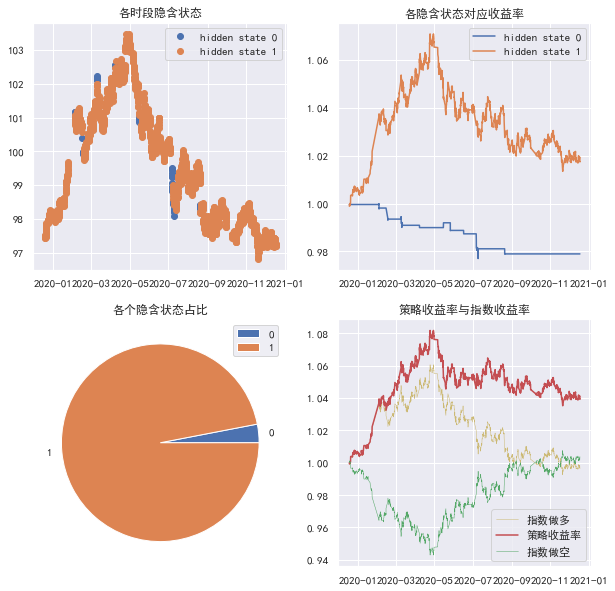

In [14]:
operate_df=get_result(model,templist,test) # 高收益隐含状态买入，
result_plot(operate_df);

## 所有数据均纳入训练集

[[0.50003486 0.49996514]
 [0.50001603 0.49998397]]
策略收益率:2.06%,基准收益率：4.66%，超额收益率：-2.59%
调仓次数：1090，预估交易手续费：0.00%
总时段数：6563，做空时段：1950


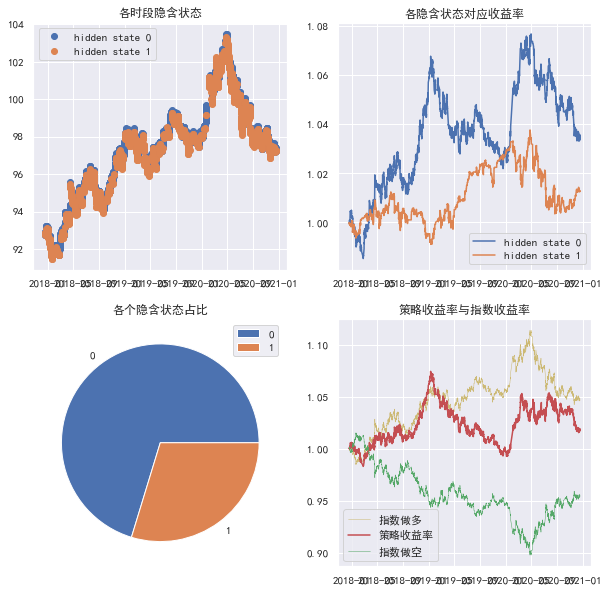

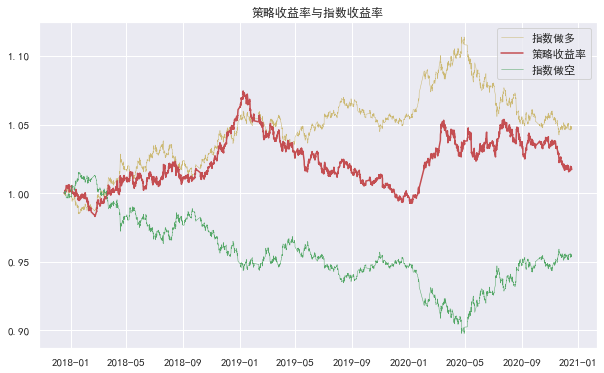

In [15]:
n=2
# margin=0.02 # 保证金比率，如果考虑杠杆，则使用此
# fee=0.00015 # (2万元-->100万合约-->3元) # 但我们没有使用杠杆收益率


model=train_model(data_raw) # 使用训练集训练模型
print(model.transmat_)
templist=model_order(model,data_raw) # 使用模型得到隐含状态排名
operate_df=get_result(model,templist,data_raw) # 高收益隐含状态买入，
result_plot(operate_df);
result_plot(operate_df,only=True);

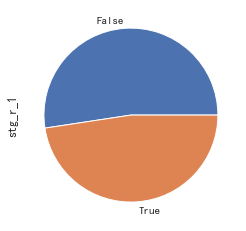

In [16]:
(operate_df['stg_r_1']>0).value_counts().plot.pie()

In [17]:
print (model.startprob_)
print (model.transmat_)
print(model.monitor_)
model.covars_

[0.49627232 0.50372768]
[[0.50003486 0.49996514]
 [0.50001603 0.49998397]]
ConvergenceMonitor(
    history=[66547.16268533378, 66547.16694852791],
    iter=3,
    n_iter=200000,
    tol=0.01,
    verbose=False,
)


array([[[3.34212292e-06, 3.01305973e-06],
        [3.01305973e-06, 6.71220637e-06]],

       [[3.34509552e-06, 3.00754045e-06],
        [3.00754045e-06, 6.71931785e-06]]])

In [18]:
import joblib
# 保存模型训练结果
joblib.dump(model,'model.pkl')

['model.pkl']

## 对每个合约时间段单独考虑

In [19]:
# for i  in range(len(change_day.index)-1):    
#     if i!=len(change_day.index)-1:
#         start=(change_day.index[i])
#         if start < data_raw.index[0]:
#             continue
#         end=(change_day.index[i+1])
#         print('开始时间：{}，结束时间：{}(不含)'.format(str(start)[:10],str(end)[:10]))
#         one_contract=data_raw[start:end]
# #         print(one_contract)

#     else:
#         start=(change_day.index[i])
#         print('开始时间：{}，结束时间：{}(不含)'.format(str(start)[:10],str(data_raw.index[-1])[:10]))
#         one_contract=data_raw[start:]
#     one_contract=data_raw[start:end]
#     operate_df=get_result(model,templist,one_contract) # 高收益隐含状态买入，
#     result_plot(operate_df)
    

## 对模型的输出结果进行一个统计

In [20]:
operate_df['time']=list(map(lambda x:str(x)[-8:] ,operate_df.index))
operate_df

,close,logReg_1,states,long,short,stg_r_1,stg_r,index_r,index_r_short,trade,adj_r,state_ret0,state_ret1,time
Date,,,,,,,,,,,,,,
2017-12-18 14:15:00,92.880,-0.000161,1,0,0,0.000000,1.000000,0.999839,1.000161,True,0.999997,-0.000161,-0.000161,14:15:00
2017-12-18 14:45:00,92.835,-0.000485,1,0,1,0.000485,1.000485,0.999354,1.000646,True,1.000479,-0.000000,-0.000485,14:45:00
2017-12-18 15:15:00,92.860,0.000269,1,0,1,-0.000269,1.000215,0.999623,1.000377,False,1.000209,0.000000,0.000269,15:15:00
2017-12-19 09:45:00,92.870,0.000108,1,0,1,-0.000108,1.000108,0.999731,1.000269,False,1.000102,0.000000,0.000108,09:45:00
2017-12-19 10:15:00,92.845,-0.000269,1,0,1,0.000269,1.000377,0.999462,1.000539,False,1.000371,-0.000000,-0.000269,10:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-17 13:30:00,97.265,0.000257,0,1,0,0.000257,1.021003,1.047042,0.955071,True,1.017673,0.000257,0.000000,13:30:00
2020-12-17 14:00:00,97.260,-0.000051,0,1,0,-0.000051,1.020951,1.046989,0.955120,False,1.017621,-0.000051,-0.000000,14:00:00
2020-12-17 14:30:00,97.225,-0.000360,1,1,0,-0.000360,1.020583,1.046612,0.955464,False,1.017254,-0.000360,-0.000000,14:30:00


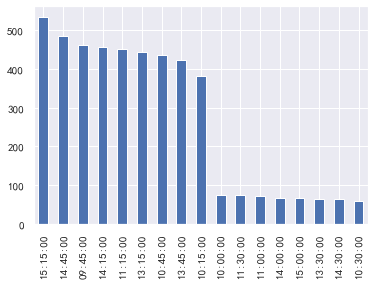

In [21]:
# 做多的时间的统计
operate_df[operate_df['long']==1]['time'].value_counts().plot.bar()

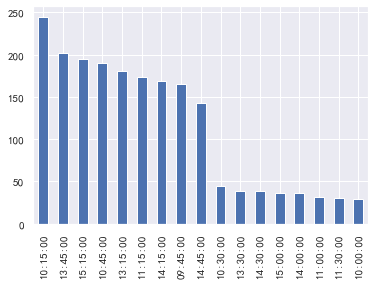

In [22]:
# 做空的时间的统计
operate_df[operate_df['short']==1]['time'].value_counts().plot.bar()

In [23]:
# short_rr.sort_values()

In [24]:
# pd.Series(list(map(lambda x:str(x)[-8:] ,short_rr.index))).value_counts().head(10).plot.bar()